# Project : Walmart Sales in Stormy Weather
---

# 1. Data Introduce
### 1.1 Purpose : Predict how sales of weather-sensitive products are affected by snow and rain
    

### 1.2 Data set:
   > - Train Data : 4617600 rows, 4 columns

   > - Test Data  : 526917 rows, 3 columns

   > - Weather Data : 20517 rows, 20 columns
   
   > - Key Data : 45 rows, 2 columns
   
   > - [링크 : Walmart Recruiting II: Sales in Stormy Weather](https://www.kaggle.com/c/walmart-recruiting-sales-in-stormy-weather)

### 1.3 Evaluation
   > - Root Mean Squared Logarithmic Error (RMSLE)  

$$
RMSLE = \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 }
$$


In [22]:
# Import libraries

import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from patsy import dmatrix
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from scipy import stats
from statsmodels.graphics import utils
from statsmodels.stats.outliers_influence import variance_inflation_factor as vifval

# Import the functions used in this project
import my_functions as mf 

from datetime import datetime
from dateutil.parser import parse

# Pretty display for notebooks
%matplotlib inline


# Ignore the warnings
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
train = pd.read_csv("asset/train.csv")
test = pd.read_csv("asset/test.csv")
weather = pd.read_csv("asset/weather.csv")
key = pd.read_csv("asset/key.csv")
submission = pd.read_csv("asset/sampleSubmission.csv")

# Success - Display the first record
print("Train data : ", train.shape)
print("Test  data : ", test.shape)
print("weather  data : ", weather.shape)
print("key  data : ", key.shape)
print("submission  data : ", submission.shape)

# 원본을 유지하기 위해서 카피
df_train = train.copy()
df_test = test.copy()
df_weather = weather.copy()
df_key = key.copy()
df_submission = submission.copy()

Train data :  (4617600, 4)
Test  data :  (526917, 3)
weather  data :  (20517, 20)
key  data :  (45, 2)
submission  data :  (526917, 2)


# 2. Exploring the Data

### Train data의 모습을 살펴보자

In [23]:
print("Train data : ", df_train.shape)
print("Test  data : ", df_test.shape)

Train data :  (4617600, 4)
Test  data :  (526917, 3)


In [24]:
df_train.tail()

,date,store_nbr,item_nbr,units
4617595,2014-10-31,45,107,0
4617596,2014-10-31,45,108,0
4617597,2014-10-31,45,109,0
4617598,2014-10-31,45,110,0
4617599,2014-10-31,45,111,0


In [25]:
df_train.head(1)

,date,store_nbr,item_nbr,units
0,2012-01-01,1,1,0


In [26]:
df_train.tail(1)

,date,store_nbr,item_nbr,units
4617599,2014-10-31,45,111,0


### 2012-01-01일부터 2014-10-31일 까지 총 1035일간의 데이터이다.

In [27]:
df_test.tail()

,date,store_nbr,item_nbr
526912,2014-10-26,45,107
526913,2014-10-26,45,108
526914,2014-10-26,45,109
526915,2014-10-26,45,110
526916,2014-10-26,45,111


### train 데이터의 컬럼을 살펴보면 units 컬럼 외 에는 통계값을 계산하는 것이 의미가없다.

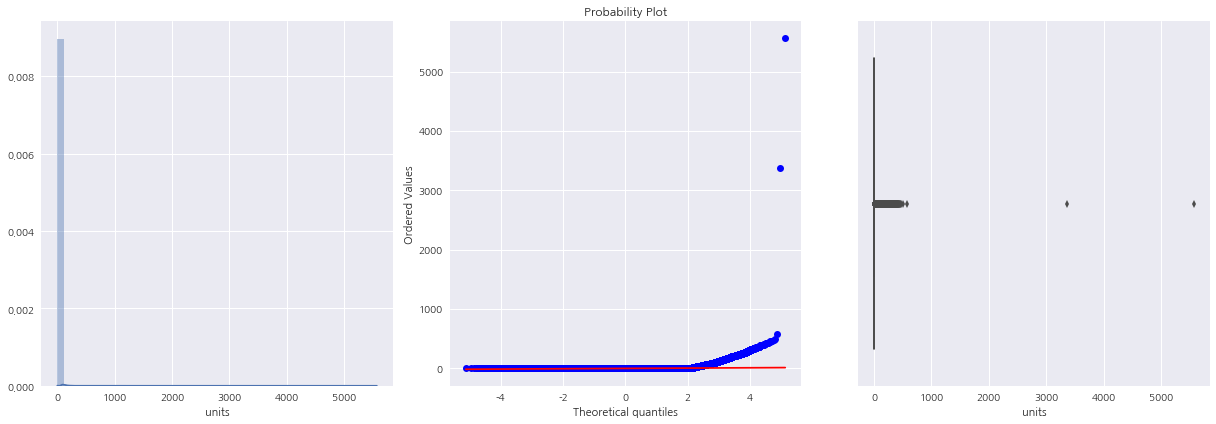

In [28]:
plt.figure(figsize=(17,6))

plt.subplot(131)
sns.distplot(df_train["units"])

plt.subplot(132)
stats.probplot(df_train["units"], plot=plt)

plt.subplot(133)
sns.boxplot(df_train["units"])
plt.tight_layout()
plt.show()

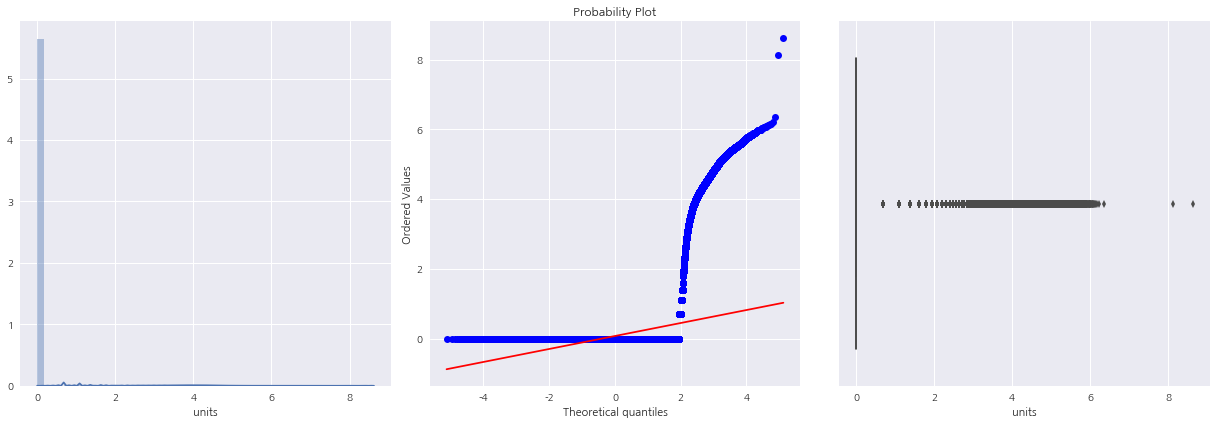

In [29]:
train_units_log1p = np.log1p(df_train["units"])

plt.figure(figsize=(17,6))

plt.subplot(131)
sns.distplot(train_units_log1p)

plt.subplot(132)
stats.probplot(train_units_log1p, plot=plt)

plt.subplot(133)
sns.boxplot(train_units_log1p)
plt.tight_layout()
plt.show()

In [30]:
df_train["units"].describe()

count    4.617600e+06
mean     9.868756e-01
std      9.875798e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      5.568000e+03
Name: units, dtype: float64

### units컬럼의 평균값은 0.986이다. 

# 2-2 Feature Type

### Weather 데이터가 우리에게 주어진 Feature Matrix이다.

In [31]:
df_weather.shape

(20517, 20)

In [32]:
df_weather.head()

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,1,2012-01-01,52,31,42,M,36,40,23,0,-,-,RA FZFG BR,M,0.05,29.78,29.92,3.6,20,4.6
1,2,2012-01-01,48,33,41,16,37,39,24,0,0716,1626,RA,0.0,0.07,28.82,29.91,9.1,23,11.3
2,3,2012-01-01,55,34,45,9,24,36,20,0,0735,1720,,0.0,0.00,29.77,30.47,9.9,31,10.0
3,4,2012-01-01,63,47,55,4,28,43,10,0,0728,1742,,0.0,0.00,29.79,30.48,8.0,35,8.2
4,6,2012-01-01,63,34,49,0,31,43,16,0,0727,1742,,0.0,0.00,29.95,30.47,14.0,36,13.8


In [33]:
sorted(df_weather["station_nbr"].unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

### 총 20개의 기상청의 데이터이다. 

### Numerical, Categorical Features 나누어서 확인해보자.

In [34]:
weather_data_cp = df_weather.copy()
weather_data_cp = mf.changeTypes(weather_data_cp)
numerical_features, categorical_features = mf.divideIntoNumericAndCategoricalVariables(weather_data_cp)

Numerical Features Qty : 17 

Numerical Features :  ['tmax', 'tmin', 'tavg', 'depart', 'dewpoint', 'wetbulb', 'heat', 'cool', 'sunrise', 'sunset', 'snowfall', 'preciptotal', 'stnpressure', 'sealevel', 'resultspeed', 'resultdir', 'avgspeed'] 


Categorical Features Qty : 2 

Categorical Features : ['station_nbr', 'codesum']


### Comment
    1. Walmart로부터 제공받은 weather 관련 document에 따르면 M, T, - Data가 포함되어있다.

Variables with Missing Qty :  [17]
Total Missing values Qty :  [51752]


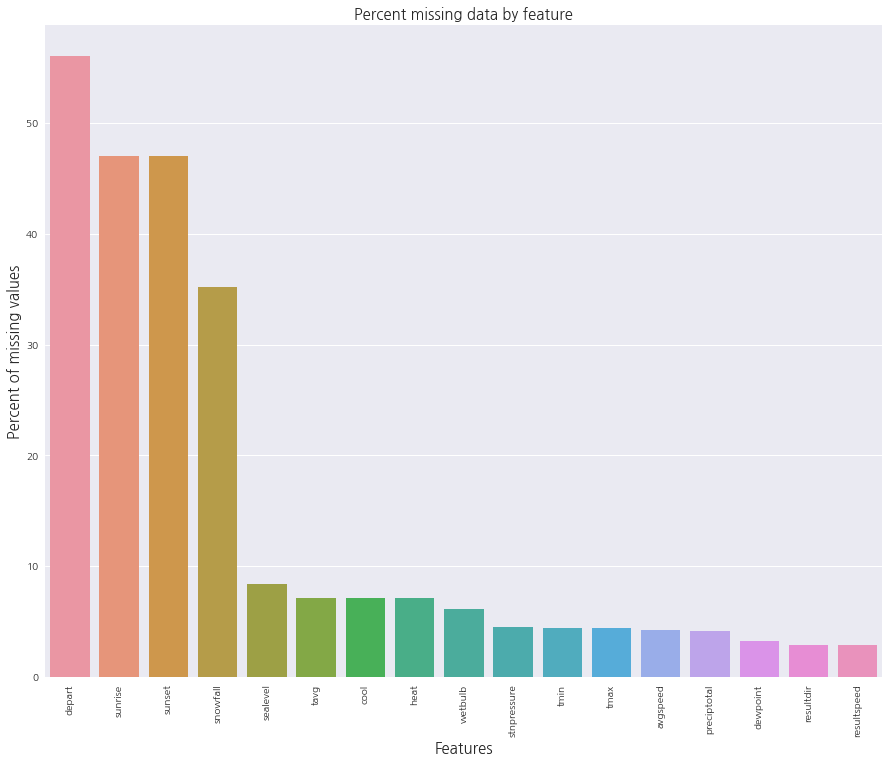

In [35]:
# Chck missing values 
weather_data_null = weather_data_cp.isnull().sum()
weather_data_null = weather_data_null.drop(weather_data_null[weather_data_null == 0].index).sort_values(ascending=False)
weather_data_missing = pd.DataFrame({'Missing Numbers' :weather_data_null})
weather_data_null =  weather_data_null / len(weather_data_cp)*100

# Barplot missing values
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=weather_data_null.index, y=weather_data_null)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

print("Variables with Missing Qty : " , weather_data_missing.count().values)
print("Total Missing values Qty : " , weather_data_missing.sum().values)

### Comment
    2. 전체적으로 Depart, Sunrise, Sunset, Snowfall은 Missing Value가 많이 포함되어있다.

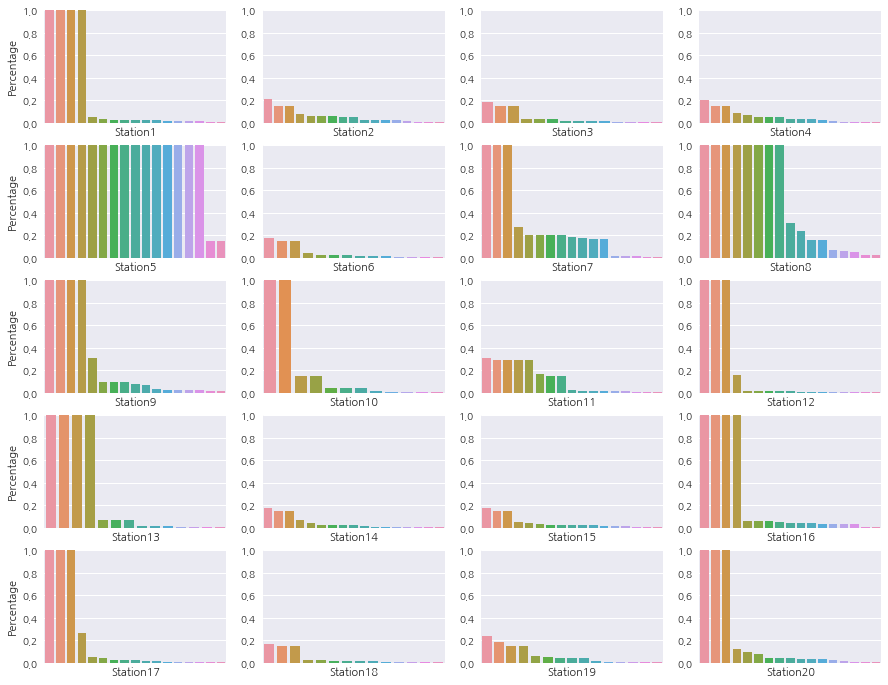

In [36]:
f, ax = plt.subplots(5, 4, figsize=(15, 12))

for idx, station in enumerate(sorted(weather_data_cp["station_nbr"].unique())):
    df = weather_data_cp.copy()
    station_weather = df[df["station_nbr"] == station]
    # Chck missing values 
    weather_data_null = station_weather.isnull().sum()
    weather_data_null = weather_data_null.drop(weather_data_null[weather_data_null == 0].index).sort_values(ascending=False)
    weather_data_missing = pd.DataFrame({'Missing Numbers' :weather_data_null})
    weather_data_null =  weather_data_null / len(weather_data_cp)*100
    # Barplot missing values
    sns.barplot(x=weather_data_null.index, y=weather_data_null\
               , ax = ax[idx//4, idx%4])
    ax[idx//4, 0].set_ylabel("Percentage")
    ax[idx//4, idx % 4].set_ylim(0, 1)
    ax[idx//4, idx % 4].set_xticks([])
    ax[idx//4, idx % 4].set_xlabel("Station" + str(station))

### Comment
    3. Station 별로 Missing 데이터 개수가 다르다. 5번은 특히 거의 Missing value로 이루어져있다.

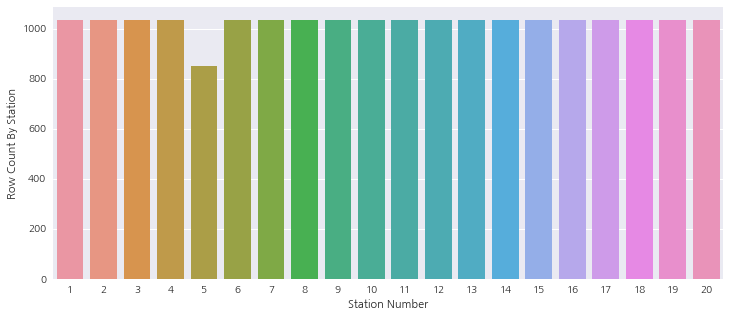

In [37]:
plt.figure(figsize=(12, 5))
sns.barplot(sorted(df_weather["station_nbr"].unique()), list(df_weather.groupby("station_nbr").size()))
plt.ylabel("Row Count By Station")
plt.xlabel("Station Number")
plt.show()

### Comment
    4. 5번 스테이션만 전체 데이터가 부족하다(2012-01-01 부터 2014-10-31까지가 아니다).

In [38]:
mf.classifyStoresByStation(df_key).sort_values(by = "station_nbr").reset_index(drop=True)

,station_nbr,store_nbr
0,1,1
1,2,16
2,3,"21, 29, 33"
3,4,8
4,5,35
5,6,"7, 13"
6,7,"3, 20, 28"
7,8,39
8,9,"4, 24"
9,10,"11, 22, 27"


### Comment
    4. 매장마다 날씨 정보를 받는 기상청이 다르다.

# 3. Feature Engineering

## 3-1 Train Preprocessing

### 3-1-1 Train

In [39]:
df_unit_sales = df_train.pivot_table(["units"], ["store_nbr"], ["item_nbr"], aggfunc=np.sum)
df_unit_sales.tail()

units                                             ...              \
item_nbr    1   2    3    4      5   6   7   8      9   10  ... 102 103 104   
store_nbr                                                   ...               
41            0   0    0    0      0   0   0   0      0   0 ...   0   0   0   
42            0   0    0    0  35178   0   0   0      0   0 ...   0   0   0   
43            0   0  675    0      0   0   0   0      0   0 ...   0   0   0   
44            0   0    0    0  32834   0   0   0      0   0 ...   0   0   0   
45            0   0    0  348      0   0   0   0  15833   0 ...   0   0   0   

                                         
item_nbr  105 106 107   108 109 110 111  
store_nbr                                
41          0   0   0  2045   0   0   0  
42          0   0   0     0   0   0   0  
43         72   0   0     0   0   0   0  
44         83   0   0     0   0   0   0  
45          0   0   0     0   0   0   0  

[5 rows x 111 columns]

### Comment
    1. 모든 상점에서 같은 종류의 아이템들을 파는 것이 아니다.

In [40]:
item_nbrs, store_nbrs = mf.report_item_sales(df_train)

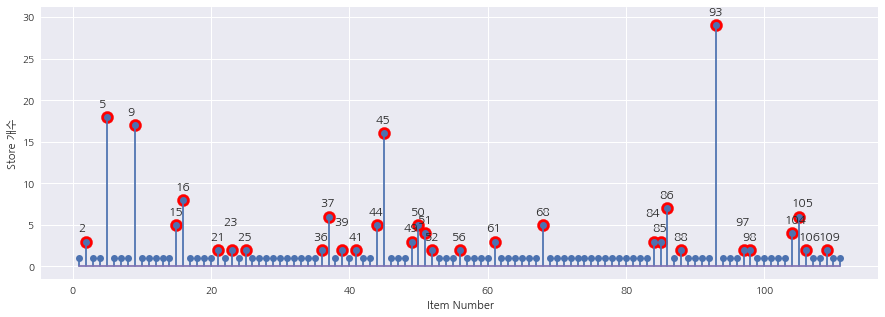

In [41]:
plt.figure(figsize=(15, 5))
item_nbrs = np.array(item_nbrs)
store_nbrs = np.array(store_nbrs)
plt.xlabel("Item Number")
plt.ylabel("Store 개수")
plt.stem(item_nbrs, store_nbrs)
ax = plt.subplot()
idx = np.where(store_nbrs > 1)
plt.scatter(item_nbrs[idx], store_nbrs[idx], s=150, c="r")
item_nbrs_ = list(idx[0])
loc = mf.setAnnotateLocation(item_nbrs_)
utils.annotate_axes(range(len(item_nbrs_)), item_nbrs[item_nbrs_],\
                    list(zip(item_nbrs[item_nbrs_], store_nbrs[item_nbrs_])), loc, size="large", ax=ax)
plt.show()

### Comment
    2. 그나마 93번이 가장 많은 상점에서 판매하고 있는 상품이지만 29곳밖에 안된다.

In [42]:
units_sales = []
for idx in list(df_unit_sales.units.columns):
    units_sales.append(df_unit_sales.units[idx].sum())
units_sales = np.array(units_sales)

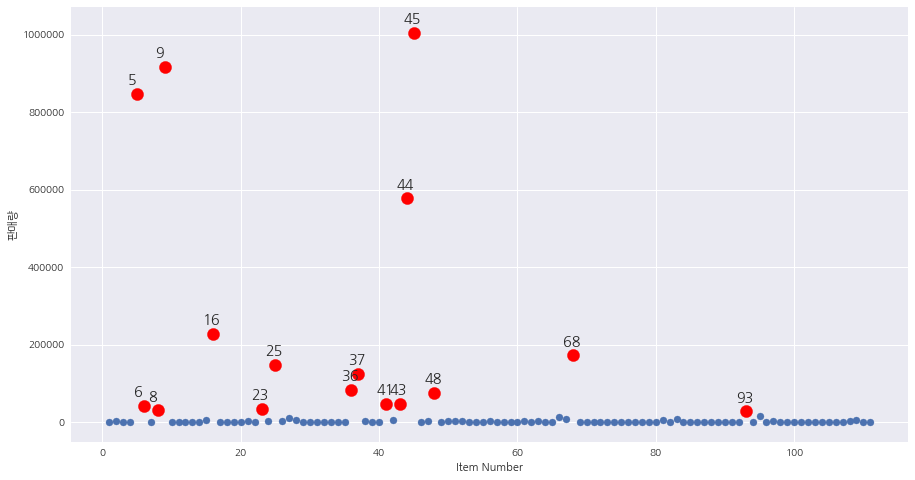

                 0
count      111.000
mean     41054.027
std     161096.077
min         31.000
25%        526.000
50%        781.000
75%       2845.000
max    1005111.000 

Skewness: 4.979809
Kurtosis: 24.816016


In [43]:
df_units_sales_sum = pd.DataFrame(units_sales)
plt.figure(figsize=(15, 8))
plt.xlabel("Item Number")
plt.ylabel("판매량")
plt.scatter(df_unit_sales.units.columns, units_sales)
ax = plt.subplot()
units_idx = np.where(units_sales > 20000)
plt.scatter(df_unit_sales.units.columns[units_idx], units_sales[units_idx], s=150, c="r")
units_nbrs = list(units_idx[0])
utils.annotate_axes(range(len(units_nbrs)), df_unit_sales.units.columns[units_nbrs],\
                    list(zip(df_unit_sales.units.columns[units_nbrs], units_sales[units_nbrs]))\
                    , [(-10, 10)] * len(units_nbrs), size="x-large", ax=ax)
plt.show()

print(round(df_units_sales_sum.describe(), 3),"\n")

print("Skewness: %f" % df_units_sales_sum.skew())
print("Kurtosis: %f" % df_units_sales_sum.kurt())

### Comment
    3. 아이템마다 판매된 유닛수는 일정하지않다.

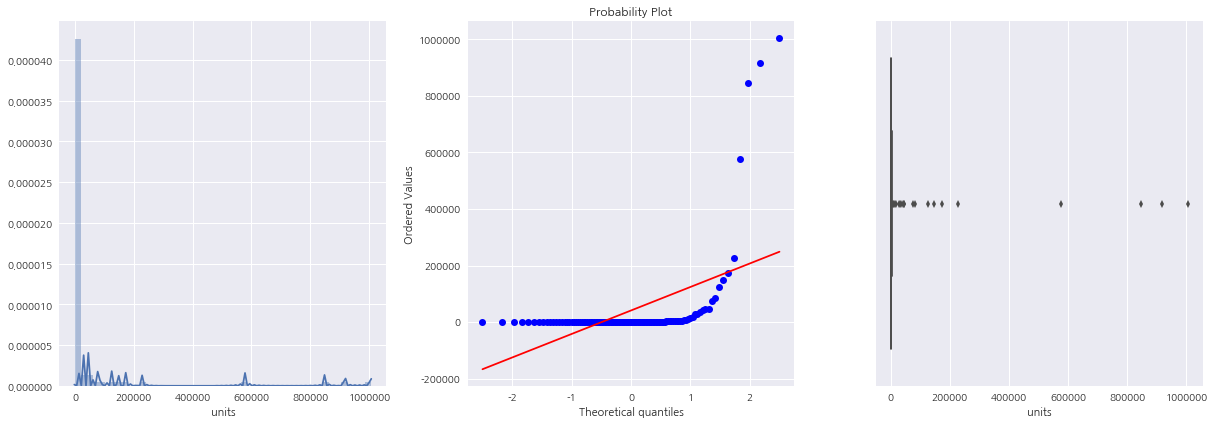

In [44]:
plt.figure(figsize=(17,6))

plt.subplot(131)
plt.xlabel("units")
sns.distplot(units_sales)

plt.subplot(132)
stats.probplot(units_sales, plot=plt)

plt.subplot(133)
plt.xlabel("units")
sns.boxplot(units_sales)
plt.tight_layout()
plt.show()

### Comment
    4. 아이템별로 판매되는 유닛수는 정규분포를 전혀 따르지않는다.

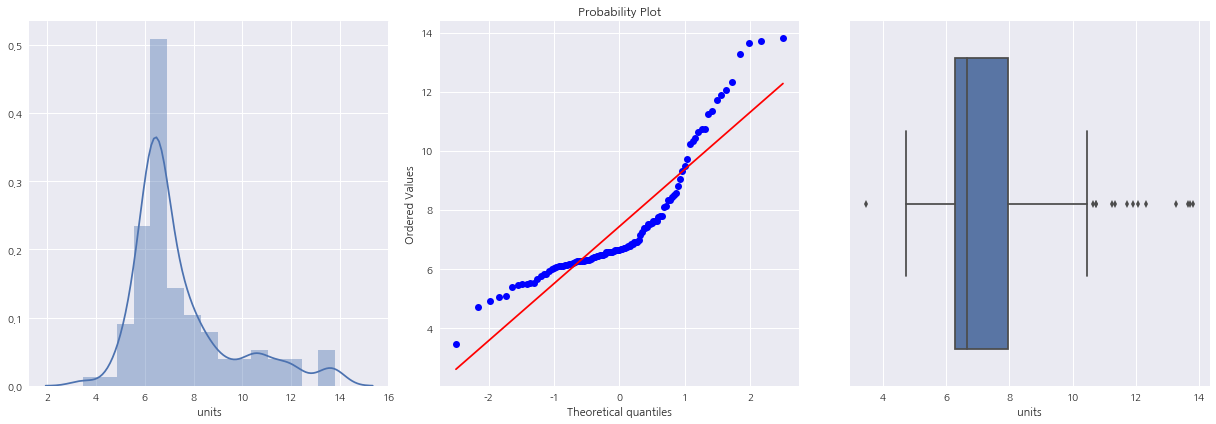

In [45]:
nomalized_SalePrice = np.log1p(units_sales)

plt.figure(figsize=(17,6))

plt.subplot(131)
plt.xlabel("units")
sns.distplot(nomalized_SalePrice)

plt.subplot(132)
stats.probplot(nomalized_SalePrice, plot=plt)

plt.subplot(133)
plt.xlabel("units")
sns.boxplot(nomalized_SalePrice)
plt.tight_layout()
plt.show()

### Comment
    5. Log값을 취하면 정규분포로 조금은 다가서는것을 확인할 수 있다.
    6. Log값으로 스케일링하는게 units그대로 쓰는 것보다는 좋아보인다.

In [46]:
def valid_item_by_station(_df):
    df = _df.copy()
    df['log1p'] = np.log1p(df['units'])
    
    store_and_item_group = df.groupby(["store_nbr", "item_nbr"])['log1p'].mean()
    store_and_item_group = store_and_item_group[store_and_item_group > 0.0]
    
    store_nbrs = store_and_item_group.index.get_level_values(0)
    item_nbrs = store_and_item_group.index.get_level_values(1)
    
    store_item_nbrs = sorted(zip(store_nbrs, item_nbrs), key = lambda t: t[1] * 10000 + t[0] )
    li = [sno_ino for sno_ino in zip(df_train['store_nbr'], df_train['item_nbr'])]
    li_ = [sno_ino in store_item_nbrs for sno_ino in li]
    return df[li_].reset_index(drop = True)

In [47]:
df_train = train.copy()
df_train = valid_item_by_station(df_train)

In [48]:
df_train.tail()

,date,store_nbr,item_nbr,units,log1p
236033,2014-10-31,45,9,10,2.397895
236034,2014-10-31,45,22,0,0.000000
236035,2014-10-31,45,26,1,0.693147
236036,2014-10-31,45,34,0,0.000000
236037,2014-10-31,45,50,0,0.000000


In [49]:
df_train.shape

(236038, 5)

### Comment
    7. 상점별로 팔지않는 아이템에 대한 Row는 다 제거했다. (460만 rows -> 23만 rows)

### 3-1-2 Weather

### Comment

    1. 앞서 확인했듯 5번 스테이션은 19개 중에서 11개의 컬럼이 95퍼센트 이상이 Missing value이며, 
       4개의 컬럼이 50퍼센트 이상의 Missing value를 가지고 있으므로 먼저 제거한다.

In [50]:
df_weather_codesum = weather_data_cp.copy()
df_weather_codesum = df_weather_codesum[df_weather_codesum["station_nbr"] != 5]

In [51]:
df_weather_codesum.shape

(19665, 20)

In [52]:
df_weather = df_weather[df_weather["station_nbr"] != 5]

In [53]:
df_weather['year'] = df_weather['date'].apply(mf.handle_date_Y)
df_weather['month'] = df_weather['date'].apply(mf.handle_date_M)
df_weather['day'] = df_weather['date'].apply(mf.handle_date_D)

#### Missing Data 선형으로 처리
    1. tmax, tmin : 일 최고기온, 일 최저기온
    2. dewpoint: 평균 이슬점
    3. preciptotal: 총 강수량
    4. stnpressure, sealevel: 특정고도에서 관측된 실제 기압, 해면기압
    5. resultspeed, resultdir, avgspeed: 합성풍속, 합성풍향, 평균풍속

In [54]:
df_weather['tmax'] = df_weather['tmax'].apply(mf.changeTypeToInt)
df_weather['tmin'] = df_weather['tmin'].apply(mf.changeTypeToInt)
df_weather['dewpoint'] = df_weather['dewpoint'].apply(mf.changeTypeToInt)
df_weather['preciptotal'] = df_weather['preciptotal'].apply(mf.changeTypeToFloat)
df_weather['stnpressure'] = df_weather['stnpressure'].apply(mf.changeTypeToFloat)
df_weather['sealevel'] = df_weather['sealevel'].apply(mf.changeTypeToFloat)
df_weather['resultspeed'] = df_weather['resultspeed'].apply(mf.changeTypeToFloat)
df_weather['resultdir'] = df_weather['resultdir'].apply(mf.changeTypeToInt)
df_weather['avgspeed'] = df_weather['avgspeed'].apply(mf.changeTypeToFloat)

# interpolate()
df_weather['tmax'] = df_weather['tmax'].interpolate()
df_weather['tmin'] = df_weather['tmin'].interpolate()
df_weather['dewpoint'] = df_weather['dewpoint'].interpolate()
df_weather['preciptotal'] = df_weather['preciptotal'].interpolate()
df_weather['stnpressure'] = df_weather['stnpressure'].interpolate()
df_weather['resultspeed'] = df_weather['resultspeed'].interpolate()
df_weather['resultdir'] = df_weather['resultdir'].interpolate()
df_weather['avgspeed'] = df_weather['avgspeed'].interpolate()

### Missing Data 선형 외 처리

#### tavg
- Description: 일 평균기온
- Process
    - tmax와 tmin의 평균값으로 Nan Data 채워줌

In [55]:
df_weather['tavg'] = df_weather['tavg'].apply(mf.changeTypeToInt)
df_weather['tavg'] = (df_weather['tmax'] + df_weather['tmin']) / 2

#### depart
- Description: 일 평균기온에서 같은 날짜의 30년 평균기온을 뺀 값
- Process
    - 1) 30년 평균을 해당 월의 3년 평균기온으로 대체
    - 2) `일 평균기온에서 각 스테이션별 해당 월의 3년 평균기온을 뺀 값`으로 채워줌

In [56]:
df_weather['depart'] = df_weather['depart'].apply(mf.changeTypeToInt)
# depart_base 컬럼 생성 -> 각 스테이션의 월마다 tavg의 평균 대입
df_weather_depart_total = pd.DataFrame(columns = ["station_nbr", "date","depart_base"])
for i in range(1,21):
    for j in range(1,13):
        df_weather_depart = df_weather[(df_weather['station_nbr']== i)&(df_weather['month']== j)]
        df_weather_depart['depart_base'] = df_weather[(df_weather['station_nbr']== i)&(df_weather['month']== j)]['tavg'].mean()
        df_weather_depart = df_weather_depart[["station_nbr", "date","depart_base"]]
        df_weather_depart_total = pd.concat([df_weather_depart_total, df_weather_depart])
        
df_weather_depart_total["station_nbr"]=df_weather_depart_total["station_nbr"].astype(int)
df_weather = df_weather.merge(df_weather_depart_total, on=["station_nbr", "date"], how='outer')

In [57]:
# depart값이 있으면 depart값을 넣고 아니면 그날의 tavg값에서 depart_base값을 뻄
df_weather['depart'] = np.where(pd.notnull(df_weather['depart']) == True, df_weather['depart'], df_weather['tavg'] - df_weather['depart_base'])

#### wetbulb
- Description: 평균 습구
- Process
    - 각 스테이션별 해당 월의 평균 wetbulb 값으로 채워줌

In [58]:
# wetbulb값은 연속적으로 missing 데이터가 있는 경우가 많아 interpolate명령어 x
df_weather_wetbulb_total = pd.DataFrame(columns = ["station_nbr", "date","wetbulb"])
for i in range(1,21):
    for j in range(1,13):
        df_weather_wetbulb = df_weather[(df_weather['station_nbr']== i)&(df_weather['month']== j)][["station_nbr", "date","wetbulb"]]
        df_weather_wetbulb = df_weather_wetbulb.fillna(df_weather_wetbulb.mean())
        df_weather_wetbulb_total = pd.concat([df_weather_wetbulb_total, df_weather_wetbulb])

In [59]:
# 각 스테이션별 해당 월의 평균 wetbulb 계산
df_weather_wetbulb_total.rename(columns={"wetbulb":"wetbulb_avg"}, inplace = True)
df_weather_wetbulb_total["station_nbr"]=df_weather_wetbulb_total["station_nbr"].astype(int)
df_weather = df_weather.merge(df_weather_wetbulb_total, on=["station_nbr", "date"])

In [60]:
df_weather['wetbulb'] = np.where(pd.notnull(df_weather['wetbulb']) == True, df_weather['wetbulb'], df_weather['wetbulb_avg'])
df_weather['wetbulb'] = df_weather['wetbulb'].apply(mf.changeTypeToInt)
df_weather = df_weather.drop(['wetbulb_avg'],axis=1)

#### heat, cool
- Description: 건물이 화씨 65도를 유지하기 위해 필요한 난방/냉방 게이지
- Process
    - heat: 화씨 65에서 일 평균기온을 뺀 값
    - cool: 일 평균기온에서 화씨 65도를 뺀 값(0이하일 경우 0으로 처리)

In [61]:
df_weather['tavg'] = df_weather['tavg'].apply(mf.changeTypeToInt)
df_weather['heat'] = df_weather['heat'].apply(mf.changeTypeToInt)
df_weather['cool'] = df_weather['cool'].apply(mf.changeTypeToInt)

In [62]:
df_weather['heat'] = 65-df_weather['tavg']
df_weather['cool'] = df_weather['tavg']-65
df_weather['cool'] = np.where(df_weather['cool'] < 0, 0,df_weather['cool'])

### Missing Data 열삭제

#### sunrise, sunset
- Description: 일출시간, 일몰시간
- Process: 데이터 전체가 없는 기상관측소가 20개중 9개이므로 채울 수 없음(열 삭제)

In [63]:
df_weather["sunrise"] = df_weather["sunrise"].apply(mf.changeTypeToInt)
df_weather["sunset"] = df_weather["sunset"].apply(mf.changeTypeToInt)

In [64]:
df_weather_sunrise_count = df_weather.copy()
df_weather_sunrise_count["sunrise_count"] = df_weather["sunrise"].apply(mf.isnan)
df_weather_sunrise_count["sunset_count"] = df_weather["sunset"].apply(mf.isnan)

#### snowfall
- Description: 강설량
- Process: 데이터 전체가 없는 기상관측소가 20개중 6개이므로 채울 수 없음(열 삭제)

In [65]:
df_weather_snowfall_count = df_weather.copy()
df_weather_snowfall_count["snowfall"] = df_weather_snowfall_count["snowfall"].apply(mf.changeTypeToFloat)
df_weather_snowfall_count["snowfall_count"] = df_weather_snowfall_count["snowfall"].apply(mf.isnan)
df_weather_snowfall_count.pivot_table(["snowfall_count"], ["station_nbr"], aggfunc=np.sum)

,snowfall_count
station_nbr,
1,0
2,1024
3,1031
4,1030
6,1026
7,978
8,5
9,18
10,0


In [66]:
df_weather_sunrise_count.pivot_table(["sunrise_count", "sunset_count"], ["station_nbr"], aggfunc=np.sum)

,sunrise_count,sunset_count
station_nbr,,
1,0,0
2,1004,1004
3,1004,1004
4,1004,1004
6,1004,1004
7,0,0
8,0,0
9,0,0
10,1004,1004


In [67]:
def setCodesumUniqueDataList(codesum):
    codesums = str(codesum).strip().split(" ")
    for cd in codesums:
        if cd != "":
            if len(cd) > 3:
                if cd[:2] == format_d:
                    return 1
                if cd[2:] == format_d:
                    return 1
            else:   
                if cd == format_d:
                    return 1
        else:
            return 0

In [68]:
codesum_list = mf.getCodesumUniqueDataList(df_weather_codesum)
codesum_list.append("MO")
codesum_dict = dict(zip(codesum_list, mf.getCodesumFormats()))
for fm in codesum_list:
    format_d = fm
    df_weather_codesum[fm] = df_weather_codesum["codesum"].apply(setCodesumUniqueDataList)
df_weather_codesum["MO"] = df_weather_codesum["MO"].fillna(1)
rows_num = []
for cd in codesum_list:
#     rows_num.append([df_weather[cd].sum(), round(df_weather[cd].sum() / len(df_weather) * 100, 2)])    
    rows_num.append(round(df_weather_codesum[cd].sum() / len(df_weather_codesum) * 100, 2))    
codesum_num = rows_num

In [69]:
df_weather_codesum = df_weather_codesum.fillna(0)

In [70]:
df_train_cp = train.copy()
df_train_cp = df_train_cp.merge(df_key, on="store_nbr")
df_train_cp = df_train_cp.merge(df_weather_codesum, on=["date", "station_nbr"])

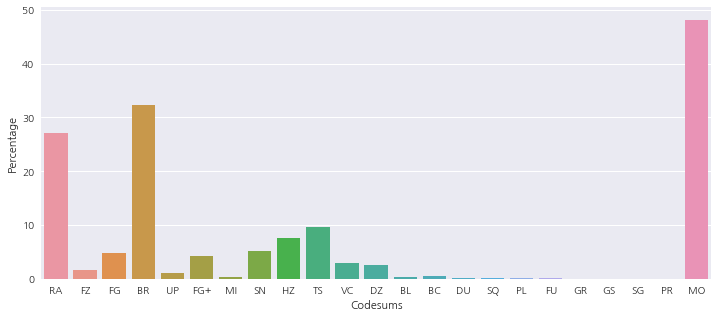

In [71]:
plt.figure(figsize=(12, 5))
sns.barplot(codesum_list, rows_num)
plt.ylabel("Percentage")
plt.xlabel("Codesums")
plt.show()

In [72]:
df_moderate = df_train_cp[df_train_cp["MO"] != 0]
test_rejected_codesum_list = []
def getUnitsByCodesum(df):
    for idx, codesum in enumerate(codesum_list):
        df_ = df[df[codesum] != 0]
        day_length = len(df_)
#         print(str(codesum) + "인 Row의 수 : " + str(day_length))
        # independent two sample test 
        statistic , p_value = sp.stats.ttest_ind(df_["units"], df_moderate["units"], equal_var = False)

        if p_value <= 0.01:
            test_rejected_codesum_list.append(codesum_dict[codesum])
            print(codesum_dict[codesum] + "이 포함된 Percentage : " + str(rows_num[idx]))
            print(round(p_value, 5))
            
getUnitsByCodesum(df_train_cp)

Freezing이 포함된 Percentage : 1.69
0.0
Snow이 포함된 Percentage : 5.13
0.0
Haze이 포함된 Percentage : 7.54
0.00026
Vicinity이 포함된 Percentage : 2.9
0.00055
Drizzle이 포함된 Percentage : 2.53
0.0003
Blowing이 포함된 Percentage : 0.3
0.00062
Patches이 포함된 Percentage : 0.56
0.0064
Ice Pellets이 포함된 Percentage : 0.1
0.00722


In [73]:
len(codesum_list), len(test_rejected_codesum_list)

(23, 8)

In [74]:
cols_to_drop = ["codesum", "sunrise", "sunset", "snowfall", "sealevel", "depart_base"]
df_weather.drop(cols_to_drop, axis=1, inplace=True)

### Comment
    1. Moderate와 비교했을 때, 23가지의 기후 중에서 8가지만 보통날과 다른 분포를 보였다.
    2. 하지만, 그런 기후들은 전체 Weather Data에서 전부 10퍼센트 미만의 날이므로 Column을 제거하기로 결정했다.

## 3-2 Feature Correlation

### 3-2-1 Numerical Features

In [75]:
df_train = df_train.merge(df_key, on="store_nbr")
df_train = df_train.merge(df_weather, on=["date", "station_nbr"])
df_train.tail()

,date,store_nbr,item_nbr,units,log1p,station_nbr,tmax,tmin,tavg,depart,...,heat,cool,preciptotal,stnpressure,resultspeed,resultdir,avgspeed,year,month,day
229225,2014-10-30,39,111,3,1.386294,8,82.0,59.0,70,-1.543011,...,-5,5,0.0,29.74,0.30,11.0,0.2,2014,10,30
229226,2014-10-31,39,9,12,2.564949,8,78.0,55.0,66,-5.543011,...,-1,1,0.0,29.82,9.65,18.5,5.1,2014,10,31
229227,2014-10-31,39,36,3,1.386294,8,78.0,55.0,66,-5.543011,...,-1,1,0.0,29.82,9.65,18.5,5.1,2014,10,31
229228,2014-10-31,39,103,4,1.609438,8,78.0,55.0,66,-5.543011,...,-1,1,0.0,29.82,9.65,18.5,5.1,2014,10,31
229229,2014-10-31,39,111,2,1.098612,8,78.0,55.0,66,-5.543011,...,-1,1,0.0,29.82,9.65,18.5,5.1,2014,10,31


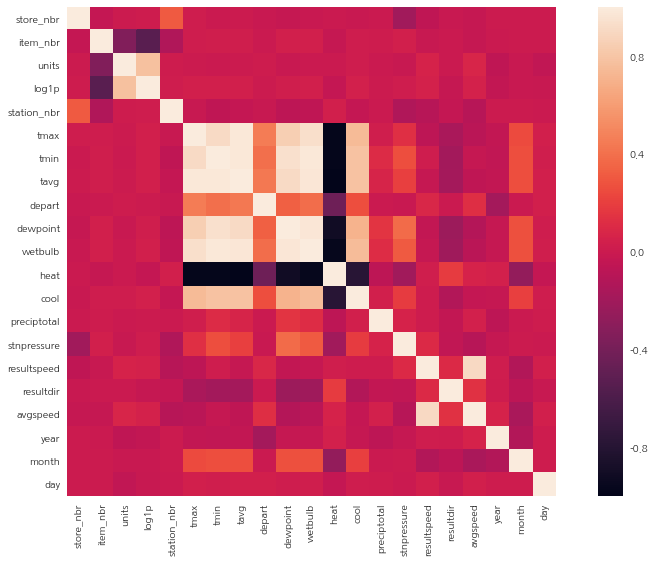

In [76]:
corrmat = df_train.corr()
f, ax = plt.subplots(figsize = (15,9))
sns.heatmap(corrmat, vmax = 1, square=True)

In [78]:
model = sm.OLS.from_formula("log1p ~ tmax + tmin + depart + dewpoint + heat + cool + preciptotal + resultspeed + resultdir + avgspeed", data=df_train)
print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  log1p   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     158.5
Date:                Sat, 07 Jul 2018   Prob (F-statistic):               0.00
Time:                        14:47:46   Log-Likelihood:            -4.5498e+05
No. Observations:              229230   AIC:                         9.100e+05
Df Residuals:                  229219   BIC:                         9.101e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0130      0.957     -0.014      

In [84]:
model = sm.OLS.from_formula("log1p ~ scale(tmax) + scale(tmin) + scale(depart) + scale(dewpoint) + scale(heat) + scale(cool) + scale(preciptotal) + scale(resultspeed) + scale(resultdir) + scale(avgspeed)", data=df_train)
print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  log1p   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     158.5
Date:                Sat, 07 Jul 2018   Prob (F-statistic):               0.00
Time:                        14:54:24   Log-Likelihood:            -4.5498e+05
No. Observations:              229230   AIC:                         9.100e+05
Df Residuals:                  229219   BIC:                         9.101e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.4922      0

## Comment : 선형으로 풀 수 있는 문제가 아니다. 

- 아이템마다 다를 것이라 판단하여 아이템 넘버 별 특성을 분석했다.

In [87]:
model = sm.OLS.from_formula("log1p ~ C(item_nbr):scale(tmax) + C(item_nbr):scale(tmin) + C(item_nbr):scale(depart) + C(item_nbr):scale(dewpoint) + C(item_nbr):scale(heat) + C(item_nbr):scale(cool) + C(item_nbr):scale(preciptotal) + C(item_nbr):scale(resultspeed) + C(item_nbr):scale(resultdir) + C(item_nbr):scale(avgspeed)", data=df_train)
print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  log1p   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     76.40
Date:                Sat, 07 Jul 2018   Prob (F-statistic):               0.00
Time:                        15:03:27   Log-Likelihood:            -4.2039e+05
No. Observations:              229230   AIC:                         8.429e+05
Df Residuals:                  228149   BIC:                         8.541e+05
Df Model:                        1080                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

### 3-3 Determination of variables using OLS model

In [79]:
# weather 변수끼리의 상관관계를 보자
# vif가 가장 높은 tavg, tmax 를 먼저 제거
df2 = df_weather[['tmin', 'depart', 'heat' ,'cool', 'preciptotal', 'resultspeed' , 'resultdir' , 'avgspeed']]
vif = pd.DataFrame()
vif['VIF Factor'] = [vifval(df2.values , i) for i in range(df2.shape[1])]
vif['Features'] = df2.columns
vif.sort_values('VIF Factor').reset_index(drop = True)

,VIF Factor,Features
0,1.133069,preciptotal
1,1.277744,depart
2,3.537193,heat
3,4.249227,cool
4,4.939743,resultdir
5,10.168523,tmin
6,21.363578,resultspeed
7,32.425780,avgspeed


### Comment
- vif가 높은 순으로 제거
- 위의 8 변수들을 최종적으로 남기기로 결정

### 3-3-1 Weather 변수만 활용한 모델
- features : item_nbr와 (cool, heat, tmin, depart, preciptotal)의 interaction

In [80]:
model = sm.OLS.from_formula("log1p ~ C(item_nbr):scale(cool)+ C(item_nbr):scale(heat) + C(item_nbr):scale(tmin) + C(item_nbr):scale(preciptotal) + C(item_nbr):scale(depart)", data=df_train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  log1p   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     91.40
Date:                Sat, 07 Jul 2018   Prob (F-statistic):               0.00
Time:                        14:48:31   Log-Likelihood:            -4.3337e+05
No. Observations:              229230   AIC:                         8.678e+05
Df Residuals:                  228689   BIC:                         8.734e+05
Df Model:                         540                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

### Comment
- Weather로 설명력 부족, item별 계절성 고려해서 Month

### 3-3-2 Weekday 변수 추가
- features : item_nbr와 (cool, heat, tmin, depart, preciptotal, `week`)의 interaction

In [81]:
def addDays(date):
    temp = date.split("-")
    year, month, date = int(temp[0]), int(temp[1]), int(temp[2])
    return datetime(year, month, date).weekday()

In [82]:
df_train["weekday"] = df_train["date"].apply(addDays)

In [83]:
model = sm.OLS.from_formula("log1p ~ C(item_nbr):scale(cool) + C(item_nbr):scale(tmin)+ C(item_nbr):scale(heat) + C(item_nbr):scale(preciptotal) + C(item_nbr):scale(depart) + C(item_nbr):C(weekday) + 0", data=df_train)
result = model.fit()
print(result.summary())

KeyboardInterrupt: 

### Lasso를 활용하여 정규화 한뒤, 교차검증

In [ ]:
matrix_df = pd.DataFrame(dmatrix("C(item_nbr):scale(cool)+ C(item_nbr):scale(heat) + C(item_nbr):scale(tmin) + C(item_nbr):scale(preciptotal) + C(item_nbr):scale(depart) + C(item_nbr):C(weekday) + 0", data=df_train))

In [ ]:
model = linear_model.Lasso(alpha = 0.01)

In [ ]:
result = model.fit(matrix_df, df_train["log1p"])

In [ ]:
result.score(matrix_df, df_train["log1p"])

In [ ]:
cv = KFold(10)

In [ ]:
kfold = cross_val_score(result,matrix_df, df_train["log1p"], scoring="r2", cv=cv)

In [ ]:
kfold, kfold.mean()

### 4 Result
- 최고 성적 : 363/485(private), (public)


In [ ]:
!["결과"]("img/result.png")